In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle

In [2]:
# load FOM solution
u=pickle.load(open("./data/FOM.p",'rb'))
u_fom=u[1:,:-1]
u_ref=u[0,:-1]
orig_data=u_fom-u_ref

# nparam
nparamArr_NMROM=np.array([2,4,6,8,10])

# avg. rel. errors
relErr_NMROM_g=np.zeros(nparamArr_NMROM.shape)
relErr_NMROM_lspg=np.zeros(nparamArr_NMROM.shape)

# avg. rel. errors
maxErr_NMROM_g=np.zeros(nparamArr_NMROM.shape)
maxErr_NMROM_lspg=np.zeros(nparamArr_NMROM.shape)

# proj. errors
proErr_NMROM=np.zeros(nparamArr_NMROM.shape)
for ii in range(len(nparamArr_NMROM)):
    nparam=nparamArr_NMROM[ii]
    
    # load weights and bias
    file_name_AE="./model/AE_v2_swish_nparam_{}.p".format(nparam)

    AE = pickle.load(open(file_name_AE,'rb'))

    en_w1=AE['en_w1']
    en_b1=AE['en_b1']
    en_w2=AE['en_w2']
    de_w1=AE['de_w1']
    de_w2=AE['de_w2']
    de_w1T=AE['de_w1T']
    de_w2T=AE['de_w2T']
    de_w2_sp=AE['de_w2_sp']
    de_w2T_sp=AE['de_w2T_sp']
    
    f = de_w1.shape[1]

    # numpy version of AE
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_np_forward(x):
        z1 = en_w1.dot(x) + en_b1
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = en_w2.dot(a1)   
        return y

    def decoder_np_forward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = de_w2.dot(a1)  
        return y

    def decoder_sp_forward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(de_w2_sp,a1)
        return y

    def decoder_np_forward_backward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = de_w2.dot(a1)

        dout = de_w1T
        dout = (s1 + a1*(1-s1))*dout
        dydxT = dout.dot(de_w2T)   
        return y,dydxT.T

    def decoder_sp_forward_backward(x):
        z1 = de_w1.dot(x) 
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(de_w2_sp,a1)

        dout = de_w1T
        dout = (s1 + a1*(1-s1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
        return y,dydxT.T

    # compute projection error
    comp_orig_data=np.zeros((orig_data.shape[0],f))
    rest_orig_data=np.zeros(orig_data.shape)
    for k in range(orig_data.shape[0]):
        comp_orig_data[k]=encoder_np_forward(orig_data[k])
        rest_orig_data[k]=decoder_sp_forward(comp_orig_data[k])

    proj=orig_data-rest_orig_data    
    pro_err=np.sqrt(np.sum(np.linalg.norm(proj,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(orig_data,ord=2,axis=1)**2))*100
    proErr_NMROM[ii]=pro_err

# NM-ROM (g) ~ $O(fmM_2)$, where $M_2$ is the number of nodes in a hidden layer of a fully dense decoder

# If a masked decoder, $O(fM_2)+O(fm^2)$, where $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [3]:
for ii in range(len(nparamArr_NMROM)):
    nparam=nparamArr_NMROM[ii]

    # load models
    file_name_AE="./model/AE_v2_swish_nparam_{}.p".format(nparam)

    AE = pickle.load(open(file_name_AE,'rb'))

    en_w1=AE['en_w1']
    en_b1=AE['en_b1']
    en_w2=AE['en_w2']
    de_w1=AE['de_w1']
    de_w2=AE['de_w2']
    de_w1T=AE['de_w1T']
    de_w2T=AE['de_w2T']
    de_w2_sp=AE['de_w2_sp']
    de_w2T_sp=AE['de_w2T_sp']

    m, M2 = de_w2.shape
    f = de_w1.shape[1]

    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def decoder_np_forward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = de_w2.dot(a1)  
        return y

    def decoder_np_forward_backward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = de_w2.dot(a1)

        dout = de_w1T
        dout = (s1 + a1*(1-s1))*dout
        dydxT = dout.dot(de_w2T)   
        return y,dydxT.T

    def decoder_sp_forward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(de_w2_sp,a1)
        return y

    def decoder_sp_forward_backward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(de_w2_sp,a1)

        dout = de_w1T
        dout = (s1 + a1*(1-s1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
        return y,dydxT.T

    def sine_wave(amp,width,nx,dx,x):

        u0 = np.zeros(nx) + 1.0
        u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
        u0[-1] = u0[0]

        return u0

    def residual_hat(u_hatn,u_hatw,uw,c,Jg_pinv,idxn1):

        # \hat r = -\hat u^n + \hat u^{n+1} - dt*J_g^{\dagger}f(g(\hat u^{n+1}))   

        f = c*(uw**2 - uw*uw[idxn1]) 

        r_hat = -u_hatn + u_hatw + Jg_pinv.dot(f)

        return r_hat

    def jacobian_hat(u,c,Jg_pinv,Jg,idxn1,I_hat):

        # \hat J = \hat I - dtJg+JfJg

        diag_comp = c*(2*u - u[idxn1])
        diag_out = (diag_comp*Jg.T).T

        subdiag_comp = -c*u[1:]
        subdiag_out = (subdiag_comp*Jg[:-1].T).T

        top_row = -c*u[0]*Jg[-1]

        JfJg = diag_out
        JfJg[1:] += subdiag_out
        JfJg[0] += top_row

        J_hat = I_hat + (Jg_pinv@JfJg)

        return J_hat

    amp = 1.0
    width = 1.0

    convergence_threshold = 1.0e-5
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 501  
    dt = 0.5 / (nt - 1)   

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1 = np.zeros(nx-1,dtype='int')
    idxn1[1:] = np.arange(nx-2)
    idxn1[0] = nx-2

    u0 = sine_wave(amp,width,nx,dx,x)
    u_hat0 = np.zeros(f,dtype='float32')

    t_total_rom_g_start=time.time()

    u_rom_g = np.zeros((nt,nx),dtype='float32')
    u_rom_g[0] = u0.astype('float32')
    u_hat = np.zeros((nt,f),dtype='float32')
    u_hat[0] = u_hat0
    I_hat = np.eye(f,dtype='float32')
    for n in range(nt-1): 
    #     print("")
    #     print(n,"th time step:")
        u_hatw = u_hat[n].copy()

        uw, Jg = decoder_sp_forward_backward(u_hatw)
        uw += u0[:-1]

        Jg_pinv = np.linalg.pinv(Jg)
        r_hat = residual_hat(u_hat[n],u_hatw,uw,c,Jg_pinv,idxn1)

        for k in range(maxk):   
            J_hat = jacobian_hat(uw,c,Jg_pinv,Jg,idxn1,I_hat)

            du_hatw = np.linalg.solve(J_hat,-r_hat) 
            u_hatw = u_hatw + du_hatw

            uw, Jg = decoder_sp_forward_backward(u_hatw)
            uw += u0[:-1]

            Jg_pinv = np.linalg.pinv(Jg)
            r_hat = residual_hat(u_hat[n],u_hatw,uw,c,Jg_pinv,idxn1)

            res = np.linalg.norm(r_hat)

    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))
#             if res < convergence_threshold:
#                 u_hat[n+1] = u_hatw.copy()
#                 u_rom_g[n+1,:-1] = uw.copy()
#                 u_rom_g[n+1,-1] = u_rom_g[n+1,0]
#                 break

#         if res >= convergence_threshold:
#             print("\n non converged after {}th iteration".format(maxk))
#             break

        u_hat[n+1] = u_hatw.copy()
        u_rom_g[n+1,:-1] = uw.copy()
        u_rom_g[n+1,-1] = u_rom_g[n+1,0]

    t_total_rom_g=time.time()-t_total_rom_g_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_g))

    rel_err=np.linalg.norm(u-u_rom_g,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)  

    print()
    print("Average relative error: {} %".format(avg_rel_err))
    print("Maximum relative error: {} %".format(max_rel_err))

    relErr_NMROM_g[ii]=avg_rel_err
    maxErr_NMROM_g[ii]=max_rel_err


Time elapsed: 1.9183547496795654 sec

Average relative error: 0.1682524918578565 %
Maximum relative error: 0.5112349987030029 %

Time elapsed: 1.920783281326294 sec

Average relative error: 0.1626429264433682 %
Maximum relative error: 0.45675361156463623 %

Time elapsed: 1.9111607074737549 sec

Average relative error: 0.16160986851900816 %
Maximum relative error: 0.4289788603782654 %

Time elapsed: 1.9150772094726562 sec

Average relative error: 0.19956107717007399 %
Maximum relative error: 0.4748023450374603 %

Time elapsed: 1.9129087924957275 sec

Average relative error: 0.18344520358368754 %
Maximum relative error: 0.45847785472869873 %


# NM-ROM (lspg) ~ $O(fmM_2)$, where $M_2$ is the number of nodes in a hidden layer of a fully dense decoder

# If a masked decoder, $O(fM_2)$, where $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [4]:
for ii in range(len(nparamArr_NMROM)):
    nparam=nparamArr_NMROM[ii]

    # load models
    file_name_AE="./model/AE_v2_swish_nparam_{}.p".format(nparam)

    AE = pickle.load(open(file_name_AE,'rb'))

    en_w1=AE['en_w1']
    en_b1=AE['en_b1']
    en_w2=AE['en_w2']
    de_w1=AE['de_w1']
    de_w2=AE['de_w2']
    de_w1T=AE['de_w1T']
    de_w2T=AE['de_w2T']
    de_w2_sp=AE['de_w2_sp']
    de_w2T_sp=AE['de_w2T_sp']

    m, M2 = de_w2.shape
    f = de_w1.shape[1]

    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def decoder_np_forward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = de_w2.dot(a1)  
        return y

    def decoder_np_forward_backward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = de_w2.dot(a1)

        dout = de_w1T
        dout = (s1 + a1*(1-s1))*dout
        dydxT = dout.dot(de_w2T)   
        return y,dydxT.T

    def decoder_sp_forward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(de_w2_sp,a1)
        return y

    def decoder_sp_forward_backward(x):
        z1 = de_w1.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(de_w2_sp,a1)

        dout = de_w1T
        dout = (s1 + a1*(1-s1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
        return y,dydxT.T

    def sine_wave(amp,width,nx,dx,x):

        u0 = np.zeros(nx) + 1.0
        u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
        u0[-1] = u0[0]

        return u0
    
    def residual_lspg(uwn,uw,c,idxn1):

        f = c*(uw**2 - uw*uw[idxn1])

        r = -uwn + uw + f

        return r

    def jacobian_lspg(u,c,Jg,idxn1):

        # J \approx J_g - \Delta t J_f J_g = (I-\delta t J_f)J_g

        diag_comp = 1.0 + c*(2*u - u[idxn1])
        diag_out = (diag_comp*Jg.T).T

        subdiag_comp = -c*u[1:]
        subdiag_out = (subdiag_comp*Jg[:-1].T).T

        top_row = -c*u[0]*Jg[-1]

        J = diag_out
        J[1:] += subdiag_out
        J[0] += top_row

        return J

    amp = 1.0
    width = 1.0

    convergence_threshold = 1.0e-5
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 501 
    dt = 0.5 / (nt - 1)  

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1=np.zeros(nx-1,dtype='int')
    idxn1[1:]=np.arange(nx-2)
    idxn1[0]=nx-2

    u0 = sine_wave(amp,width,nx,dx,x)
    u_hat0 = np.zeros(f,dtype='float32')

    t_total_rom_lspg_start=time.time()

    u_rom_lspg = np.zeros((nt,nx),dtype='float32')
    u_rom_lspg[0] = u0.astype('float32')
    u_hat = np.zeros((nt,f),dtype='float32')
    u_hat[0] = u_hat0
    I_hat = np.eye(f,dtype='float32')
    for n in range(nt-1): 
    #     print("")
    #     print(n,"th time step:")
        u_hatw = u_hat[n].copy()

        uw, Jg = decoder_sp_forward_backward(u_hatw)
        uw += u0[:-1]

        J_lspg = jacobian_lspg(uw,c,Jg,idxn1)

        r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
        r = r_lspg.dot(J_lspg)

        for k in range(maxk):   
            J = J_lspg.T.dot(J_lspg)

            du_hatw = np.linalg.solve(J,-r)

            u_hatw = u_hatw + du_hatw

            uw, Jg = decoder_sp_forward_backward(u_hatw)        
            uw += u0[:-1]

            J_lspg = jacobian_lspg(uw,c,Jg,idxn1)

            r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
            r = r_lspg.dot(J_lspg)

            res = np.linalg.norm(r)
    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

#             if res < convergence_threshold:            
#                 u_hat[n+1] = u_hatw.copy()
#                 u_rom_lspg[n+1,:-1] = uw.copy()
#                 u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]
#                 break

#         if res >= convergence_threshold:
#             print("\n non converged after {}th iteration".format(maxk))
#             break

        u_hat[n+1] = u_hatw.copy()
        u_rom_lspg[n+1,:-1] = uw.copy()
        u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]

    t_total_rom_lspg=time.time()-t_total_rom_lspg_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_lspg))
    
    rel_err=np.linalg.norm(u-u_rom_lspg,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)  

    print()
    print("Average relative error: {} %".format(avg_rel_err))
    print("Maximum relative error: {} %".format(max_rel_err))
    
    relErr_NMROM_lspg[ii]=avg_rel_err
    maxErr_NMROM_lspg[ii]=max_rel_err


Time elapsed: 1.4931073188781738 sec

Average relative error: 0.26145039591938257 %
Maximum relative error: 0.8190646767616272 %

Time elapsed: 1.4916882514953613 sec

Average relative error: 0.19654673524200916 %
Maximum relative error: 0.49990415573120117 %

Time elapsed: 1.4892919063568115 sec

Average relative error: 0.15883699525147676 %
Maximum relative error: 0.5203933715820312 %

Time elapsed: 1.49226975440979 sec

Average relative error: 0.1306684804148972 %
Maximum relative error: 0.35061001777648926 %

Time elapsed: 1.4918551445007324 sec

Average relative error: 0.12449357891455293 %
Maximum relative error: 0.3053106665611267 %


# Plot errors

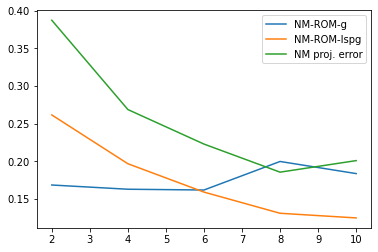

In [5]:
plt.figure()
plt.plot(nparamArr_NMROM,relErr_NMROM_g,nparamArr_NMROM,relErr_NMROM_lspg,nparamArr_NMROM,proErr_NMROM)
plt.legend(['NM-ROM-g','NM-ROM-lspg','NM proj. error'])
plt.show()

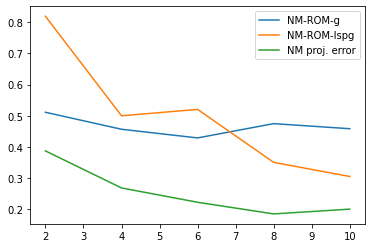

In [6]:
plt.figure()
plt.plot(nparamArr_NMROM,maxErr_NMROM_g,nparamArr_NMROM,maxErr_NMROM_lspg,nparamArr_NMROM,proErr_NMROM)
plt.legend(['NM-ROM-g','NM-ROM-lspg','NM proj. error'])
plt.show()

# Save data to mat file

In [7]:
from scipy.io import savemat, loadmat

In [8]:
dict_err={"relErr_NMROM_g":relErr_NMROM_g,"relErr_NMROM_lspg":relErr_NMROM_lspg,\
          "maxErr_NMROM_g":maxErr_NMROM_g,"maxErr_NMROM_lspg":maxErr_NMROM_lspg,\
          'proErr_NMROM':proErr_NMROM,'nparamArr_NMROM':nparamArr_NMROM}
savemat("./data/NMROM_Err_nparam.mat",dict_err)

pickle.dump(dict_err,open('./data/NMROM_Err_nparam.p','wb'))